# Imports

In [1]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 9.0 MB/s 


In [2]:
import logging
logging.getLogger("hmmlearn").setLevel("CRITICAL")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from tqdm import tqdm

from hmmlearn import hmm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset prepration

In [5]:
def prepare_dataset(data):
  
  open_price = np.array(data['Open Price'])
  high_price = np.array(data['High Price'])
  low_price = np.array(data['Low Price'])
  close_price = np.array(data['Close Price'])

  observation_dim1 = (close_price - open_price) / open_price
  observation_dim2 = (high_price - open_price) / open_price
  observation_dim3  = (open_price - low_price) / open_price
  
  dataset = np.column_stack((observation_dim1,observation_dim2,observation_dim3))
  return dataset

In [6]:
dataset_path = '/content/drive/MyDrive/machine_learning_project/Tata-steel.csv'
dataset = pd.read_csv(dataset_path)

train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)
print(f"shape of train data: {train_data.shape}")
print(f"shape of test data: {test_data.shape}")

shape of train data: (1188, 13)
shape of test data: (297, 13)


In [7]:
train_data_processed = prepare_dataset(train_data)
test_data_processed = prepare_dataset(test_data)

print(f"shape of processed train data: {train_data_processed.shape}")
print(f"shape of processed test data: {test_data_processed.shape}")

shape of processed train data: (1188, 3)
shape of processed test data: (297, 3)


# Training

In [8]:
model = hmm.GMMHMM(n_components = 6, n_mix=3)
model = model.fit(train_data_processed)

# Evaluation

In [9]:
def predict_stock(start, time_step):

  start_index = i #start index
  end_index = i + time_step #end index

  input_observations = test_data_processed[start_index:end_index,:]
  scores = []
  for output in all_possible_outputs:
    test_input = np.row_stack((input_observations,output))
    scores.append(model.score(test_input))

  index_max_score = np.argmax(scores)
  prediction = all_possible_outputs[index_max_score]
  return prediction

In [10]:
def fetch_all_possible_values(steps = 40):
    possible_values_observation1 = np.linspace(np.min(test_data_processed[:,0]), np.max(test_data_processed[:,0]), 50) 
    possible_values_observation2 = np.linspace(np.min(test_data_processed[:,1]), np.max(test_data_processed[:,1]), 10) 
    possible_values_observation3 = np.linspace(np.min(test_data_processed[:,2]), np.max(test_data_processed[:,2]), 10)  
    all_possible_outputs =  np.array(list(itertools.product(possible_values_observation1, possible_values_observation2, possible_values_observation3))) #(20*20*20,3)
    return all_possible_outputs

In [11]:
all_possible_outputs = fetch_all_possible_values()

In [12]:
time_step = 40

close_price_predictions = []
high_price_predictions = []
low_price_predictions = []
predictions = []
for i in tqdm(range(test_data.shape[0] - time_step)):
  most_probable_outcome = predict_stock(i,time_step)
  close_price_predictions.append(test_data.iloc[i]['Open Price'] * (1 + most_probable_outcome[0]))
  high_price_predictions.append(test_data.iloc[i]['Open Price'] * (1 + most_probable_outcome[1]))
  low_price_predictions.append(test_data.iloc[i]['Open Price'] * (1 + most_probable_outcome[2]))
  predictions.append(most_probable_outcome)

100%|██████████| 257/257 [25:44<00:00,  6.01s/it]


In [ ]:
import math
from sklearn.metrics import mean_squared_error
test_data_processed = test_data_processed[:len(test_data_processed)-time_step,:]
print(mean_squared_error(test_data_processed,predictions))

In [14]:
col1 = np.array(test_data.iloc[:len(test_data)-time_step,:]['Close Price']).reshape(-1,1)
col2 = np.array(test_data.iloc[:len(test_data)-time_step,:]['High Price']).reshape(-1,1)
col3 = np.array(test_data.iloc[:len(test_data)-time_step,:]['Low Price']).reshape(-1,1)
ground_truth = np.concatenate((col1,col2,col3),axis=1)

close_price_predictions = np.array(close_price_predictions).reshape(-1,1)
high_price_predictions = np.array(high_price_predictions).reshape(-1,1)
low_price_predictions = np.array(low_price_predictions).reshape(-1,1)
predicted = np.concatenate((close_price_predictions,high_price_predictions,low_price_predictions),axis=1)

print(mean_squared_error(ground_truth,predicted))

294.23009246473293


# Plotting results

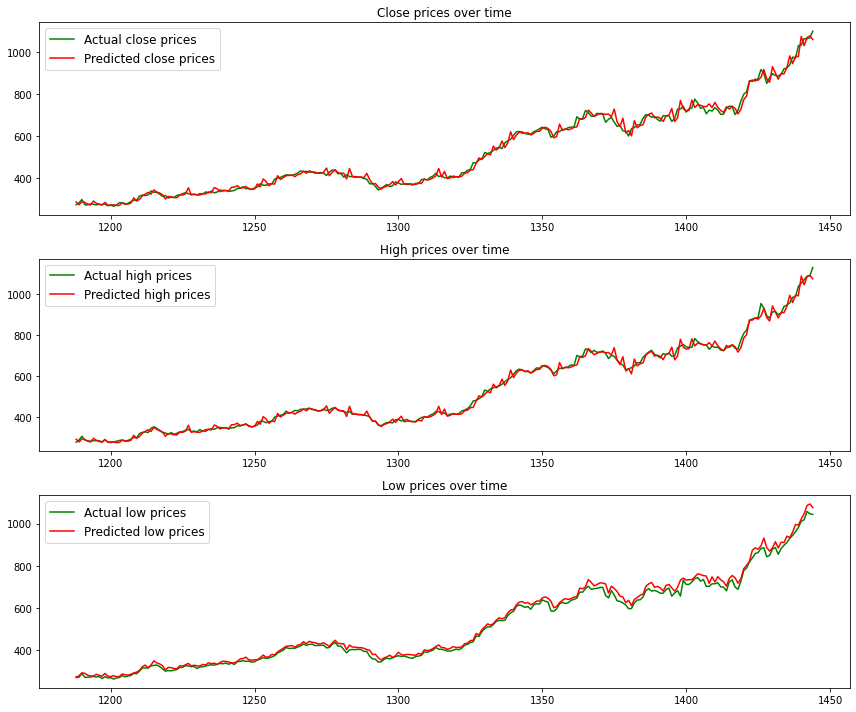

In [19]:
fig = plt.figure(1, figsize=(12,10))

x_axis = np.array(test_data.index[:len(test_data)-time_step])
plt.subplot(3,1,1)
plt.plot(x_axis, col1, 'g', label="Actual close prices")
plt.plot(x_axis, close_price_predictions, 'r', label="Predicted close prices")
plt.legend(prop={'size': 12})
plt.title('Close prices over time')

plt.subplot(3,1,2)
plt.plot(x_axis, col2, 'g', label="Actual high prices")
plt.plot(x_axis, high_price_predictions, 'r', label="Predicted high prices")
plt.legend(prop={'size': 12})
plt.title('High prices over time')

plt.subplot(3,1,3)
plt.plot(x_axis, col3, 'g', label="Actual low prices")
plt.plot(x_axis, low_price_predictions, 'r', label="Predicted low prices")
plt.legend(prop={'size': 12})
plt.title('Low prices over time')
plt.tight_layout()
plt.show()